In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


33562624/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

48799744/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

65462272/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Found 2000 files belonging to 2 classes.


I0000 00:00:1723777686.391165  124422 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723777686.394572  124422 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723777686.398160  124422 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723777686.401884  124422 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


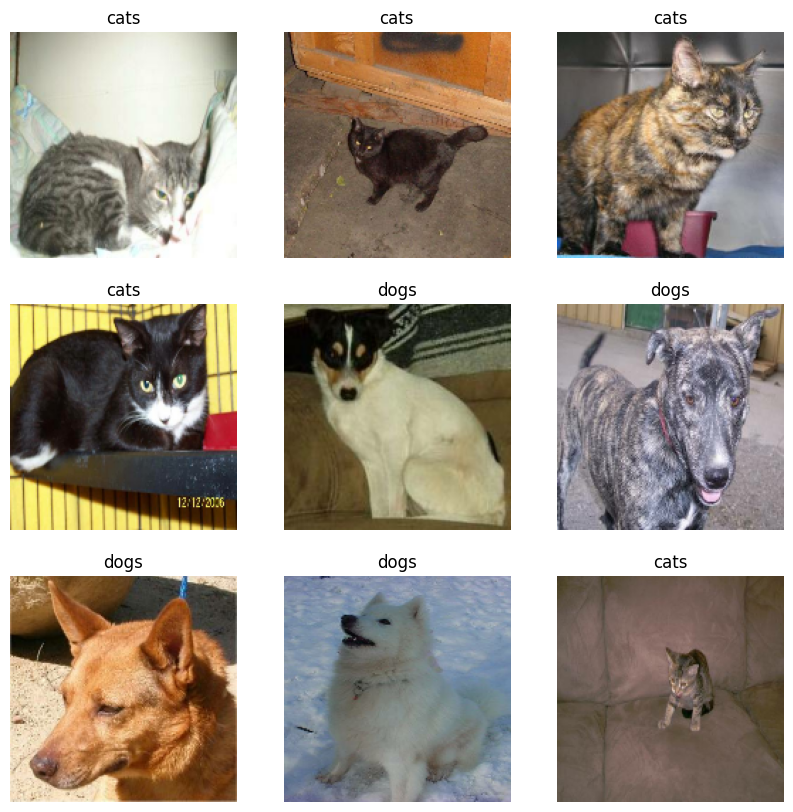

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

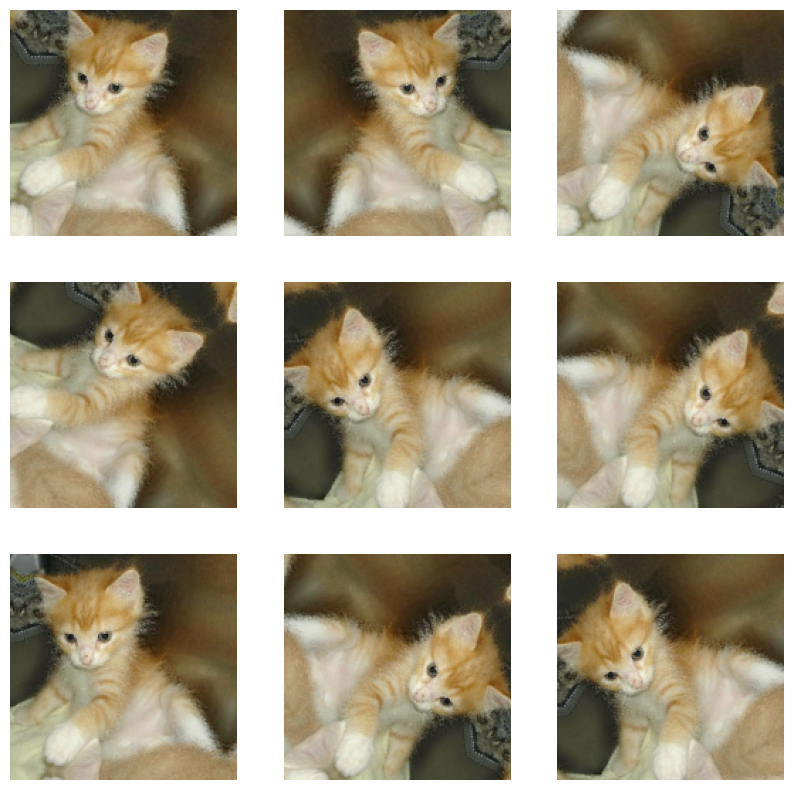

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

4202496/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [17]:
base_model.trainable = False

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [23]:
len(model.trainable_variables)

2

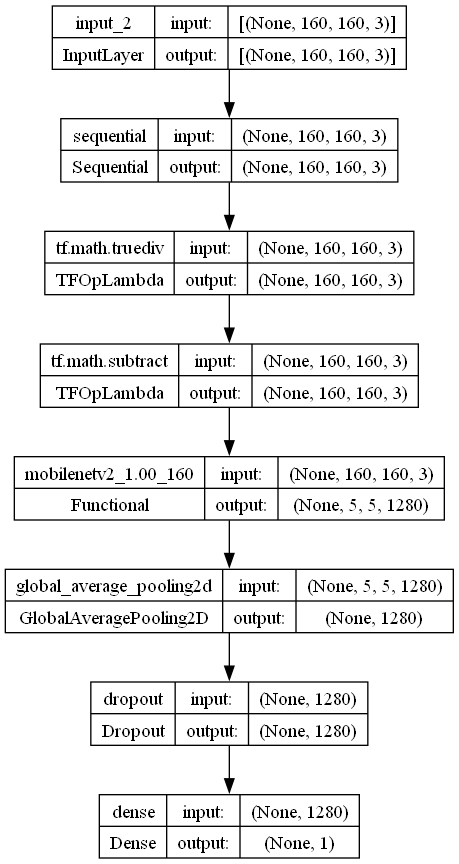

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 64ms/step - loss: 0.6620 - accuracy: 0.6151


12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5680 - loss: 0.7209

14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5652 - loss: 0.7215

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5633 - loss: 0.7211

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5624 - loss: 0.7197

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5626 - loss: 0.7179

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5634 - loss: 0.7158

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5640 - loss: 0.7140

W0000 00:00:1723777697.379556  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.380400  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.381178  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.381938  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.382708  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.383495  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.384307  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.385069  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.385821  124619 gp

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5640 - loss: 0.7129

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5639 - loss: 0.7125


W0000 00:00:1723777697.582166  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.582939  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.589370  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.590063  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.590736  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.591407  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.592071  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.592733  124619 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777697.593421  124619 gp

In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.62


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 17s 192ms/step - loss: 0.7020 - accuracy: 0.6155 - val_loss: 0.4403 - val_accuracy: 0.8329
Epoch 2/10
63/63 [==============================] - 9s 137ms/step - loss: 0.5326 - accuracy: 0.7290 - val_loss: 0.3377 - val_accuracy: 0.8886
Epoch 3/10
63/63 [==============================] - 9s 145ms/step - loss: 0.4189 - accuracy: 0.8105 - val_loss: 0.2592 - val_accuracy: 0.9270
Epoch 4/10
63/63 [==============================] - 10s 149ms/step - loss: 0.3628 - accuracy: 0.8465 - val_loss: 0.2155 - val_accuracy: 0.9480
Epoch 5/10
63/63 [==============================] - 9s 141ms/step - loss: 0.3167 - accuracy: 0.8710 - val_loss: 0.1869 - val_accuracy: 0.9629
Epoch 6/10
63/63 [==============================] - 10s 161ms/step - loss: 0.2831 - accuracy: 0.8865 - val_loss: 0.1661 - val_accuracy: 0.9629
Epoch 7/10
63/63 [==============================] - 12s 190ms/step - loss: 0.2631 - accuracy: 0.9010 - val_loss: 0.1517 - val_accuracy: 0.9629
Ep

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5749 - loss: 0.7270

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5754 - loss: 0.7253

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5759 - loss: 0.7238

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5771 - loss: 0.7222

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5784 - loss: 0.7208

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5795 - loss: 0.7196

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5807 - loss: 0.7184

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5820 - loss: 0.7170

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5834 - loss: 0.7158

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5846 - loss: 0.7145

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5858 - loss: 0.7135

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5868 - loss: 0.7126

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5880 - loss: 0.7115

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5893 - loss: 0.7103

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5905 - loss: 0.7091

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5919 - loss: 0.7077

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5932 - loss: 0.7063

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5945 - loss: 0.7048

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5959 - loss: 0.7032

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5972 - loss: 0.7018

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5985 - loss: 0.7003

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5997 - loss: 0.6990

W0000 00:00:1723777704.397737  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.398671  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.399497  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.400322  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.401154  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.402015  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.402938  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.403723  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.404513  124620 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6008 - loss: 0.6978

W0000 00:00:1723777704.599494  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.600166  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.600837  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.601515  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.602177  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.602866  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.603530  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.604222  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777704.604885  124620 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.6013 - loss: 0.6973 - val_accuracy: 0.8292 - val_loss: 0.4765


Epoch 2/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5625 - loss: 0.6844

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5764 - loss: 0.7090

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6243 - loss: 0.6747

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6466 - loss: 0.6556

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6565 - loss: 0.6434

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6626 - loss: 0.6359

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6684 - loss: 0.6293

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6735 - loss: 0.6235

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6778 - loss: 0.6178

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6815 - loss: 0.6123

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6845 - loss: 0.6075

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6874 - loss: 0.6027

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6905 - loss: 0.5979

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6933 - loss: 0.5936

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6959 - loss: 0.5898

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6984 - loss: 0.5865

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7007 - loss: 0.5833

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7030 - loss: 0.5803

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7052 - loss: 0.5774

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7071 - loss: 0.5748

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7089 - loss: 0.5724

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7106 - loss: 0.5702

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7122 - loss: 0.5681

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7138 - loss: 0.5661

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7152 - loss: 0.5642

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7165 - loss: 0.5624

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7177 - loss: 0.5607

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7189 - loss: 0.5591

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7201 - loss: 0.5575

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7212 - loss: 0.5560

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7221 - loss: 0.5546

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7236 - loss: 0.5526 - val_accuracy: 0.9047 - val_loss: 0.3534


Epoch 3/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7500 - loss: 0.4450

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7604 - loss: 0.4616

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7663 - loss: 0.4636

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7692 - loss: 0.4634

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7739 - loss: 0.4611

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7761 - loss: 0.4616

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7772 - loss: 0.4624

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7778 - loss: 0.4624

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7779 - loss: 0.4620

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7780 - loss: 0.4616

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7785 - loss: 0.4612

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7793 - loss: 0.4603

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7801 - loss: 0.4593

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7806 - loss: 0.4585

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7814 - loss: 0.4573

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7819 - loss: 0.4564

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7823 - loss: 0.4556

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7828 - loss: 0.4549

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7832 - loss: 0.4543

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7836 - loss: 0.4537

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7840 - loss: 0.4531

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7844 - loss: 0.4526

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7848 - loss: 0.4521

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7853 - loss: 0.4516

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7858 - loss: 0.4511

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7864 - loss: 0.4504

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7870 - loss: 0.4497

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7876 - loss: 0.4491

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7883 - loss: 0.4485

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7888 - loss: 0.4478

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7894 - loss: 0.4472

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7903 - loss: 0.4462 - val_accuracy: 0.9282 - val_loss: 0.2795


Epoch 4/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8125 - loss: 0.3939

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8403 - loss: 0.3769

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8523 - loss: 0.3685

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8546 - loss: 0.3655

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8576 - loss: 0.3630

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8586 - loss: 0.3606

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8590 - loss: 0.3587

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8587 - loss: 0.3582

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8584 - loss: 0.3579

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8576 - loss: 0.3581

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8577 - loss: 0.3580

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8577 - loss: 0.3579

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8579 - loss: 0.3578

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8582 - loss: 0.3579

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8581 - loss: 0.3582

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8581 - loss: 0.3584

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8579 - loss: 0.3585

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8576 - loss: 0.3587

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8574 - loss: 0.3588

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8573 - loss: 0.3587

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8572 - loss: 0.3587

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8572 - loss: 0.3588

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8569 - loss: 0.3590

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8566 - loss: 0.3591

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8564 - loss: 0.3592

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8562 - loss: 0.3592

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8562 - loss: 0.3591

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8563 - loss: 0.3589

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8563 - loss: 0.3587

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8563 - loss: 0.3585

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8563 - loss: 0.3585

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8562 - loss: 0.3583 - val_accuracy: 0.9443 - val_loss: 0.2279


Epoch 5/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9062 - loss: 0.3328

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9097 - loss: 0.3131

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9124 - loss: 0.3047

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9052 - loss: 0.3056

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8997 - loss: 0.3112

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8960 - loss: 0.3150

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8939 - loss: 0.3175

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8930 - loss: 0.3186

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8917 - loss: 0.3189

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8909 - loss: 0.3184

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8910 - loss: 0.3174

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8910 - loss: 0.3169

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8911 - loss: 0.3162

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8911 - loss: 0.3159

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8912 - loss: 0.3155

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8913 - loss: 0.3148

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8916 - loss: 0.3143

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3140

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3139

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3138

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3136

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8918 - loss: 0.3135

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8918 - loss: 0.3133

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8917 - loss: 0.3132

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8915 - loss: 0.3131

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8913 - loss: 0.3131

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8911 - loss: 0.3131

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8909 - loss: 0.3130

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8907 - loss: 0.3128

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8906 - loss: 0.3127

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8904 - loss: 0.3128

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8901 - loss: 0.3128 - val_accuracy: 0.9554 - val_loss: 0.1954


Epoch 6/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9375 - loss: 0.2704

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8889 - loss: 0.3159

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8805 - loss: 0.3255

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8699 - loss: 0.3332

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8653 - loss: 0.3360

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8633 - loss: 0.3365

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8628 - loss: 0.3352

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8637 - loss: 0.3324

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8653 - loss: 0.3291

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8670 - loss: 0.3260

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8685 - loss: 0.3233

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8698 - loss: 0.3211

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8707 - loss: 0.3190

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8716 - loss: 0.3170

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8727 - loss: 0.3149

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8737 - loss: 0.3130

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8747 - loss: 0.3112

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8758 - loss: 0.3095

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8768 - loss: 0.3078

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8779 - loss: 0.3062

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8790 - loss: 0.3046

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8801 - loss: 0.3031

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8810 - loss: 0.3019

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8818 - loss: 0.3007

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8825 - loss: 0.2997

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8832 - loss: 0.2988

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8837 - loss: 0.2980

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8842 - loss: 0.2972

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8847 - loss: 0.2964

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8852 - loss: 0.2956

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8856 - loss: 0.2949

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8862 - loss: 0.2941 - val_accuracy: 0.9567 - val_loss: 0.1724


Epoch 7/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9062 - loss: 0.3483

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9306 - loss: 0.2985

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9265 - loss: 0.2989

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9228 - loss: 0.2965

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9203 - loss: 0.2938

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9195 - loss: 0.2905

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9170 - loss: 0.2895

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9159 - loss: 0.2881

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9156 - loss: 0.2859

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9157 - loss: 0.2835

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9158 - loss: 0.2812

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9157 - loss: 0.2793

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9153 - loss: 0.2781

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9150 - loss: 0.2769

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9149 - loss: 0.2755

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9150 - loss: 0.2739

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9149 - loss: 0.2728

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9145 - loss: 0.2723

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9141 - loss: 0.2718

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9138 - loss: 0.2714

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9136 - loss: 0.2709

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9133 - loss: 0.2704

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9131 - loss: 0.2700

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9130 - loss: 0.2696

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9127 - loss: 0.2693

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9123 - loss: 0.2691

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9121 - loss: 0.2689

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9118 - loss: 0.2687

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9116 - loss: 0.2685

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9114 - loss: 0.2682

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9111 - loss: 0.2681

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9106 - loss: 0.2680 - val_accuracy: 0.9604 - val_loss: 0.1556


Epoch 8/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8750 - loss: 0.2662

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8698 - loss: 0.2745

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8759 - loss: 0.2721

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8805 - loss: 0.2695

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8825 - loss: 0.2680

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8830 - loss: 0.2676

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8839 - loss: 0.2674

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8854 - loss: 0.2662

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8875 - loss: 0.2641

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8899 - loss: 0.2618

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8920 - loss: 0.2594

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8939 - loss: 0.2575

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8959 - loss: 0.2556

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8978 - loss: 0.2537

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8994 - loss: 0.2520

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9009 - loss: 0.2506

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9023 - loss: 0.2493

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9033 - loss: 0.2483

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9039 - loss: 0.2479

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9043 - loss: 0.2477

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9046 - loss: 0.2475

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9047 - loss: 0.2476

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9048 - loss: 0.2476

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9047 - loss: 0.2478

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9047 - loss: 0.2481

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9047 - loss: 0.2484

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9048 - loss: 0.2487

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9048 - loss: 0.2489

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9048 - loss: 0.2490

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9049 - loss: 0.2490

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9049 - loss: 0.2491

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9050 - loss: 0.2492 - val_accuracy: 0.9604 - val_loss: 0.1435


Epoch 9/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9375 - loss: 0.1943

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9201 - loss: 0.2273

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9230 - loss: 0.2254

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9258 - loss: 0.2193

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9268 - loss: 0.2178

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9271 - loss: 0.2172

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9276 - loss: 0.2160

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9275 - loss: 0.2146

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9273 - loss: 0.2138

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9271 - loss: 0.2132

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9266 - loss: 0.2135

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9262 - loss: 0.2142

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9259 - loss: 0.2147

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9257 - loss: 0.2150

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9256 - loss: 0.2153

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9254 - loss: 0.2157

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9251 - loss: 0.2161

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9247 - loss: 0.2166

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9244 - loss: 0.2170

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9242 - loss: 0.2172

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9240 - loss: 0.2175

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9239 - loss: 0.2177

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9236 - loss: 0.2181

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9233 - loss: 0.2185

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9230 - loss: 0.2190

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9227 - loss: 0.2194

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9223 - loss: 0.2199

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9220 - loss: 0.2203

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9218 - loss: 0.2206

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9216 - loss: 0.2209

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9214 - loss: 0.2212

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9211 - loss: 0.2216 - val_accuracy: 0.9641 - val_loss: 0.1348


Epoch 10/10


 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9688 - loss: 0.2103

 3/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9358 - loss: 0.2372

 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9349 - loss: 0.2312

 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9322 - loss: 0.2284

 9/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9318 - loss: 0.2240

11/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9312 - loss: 0.2210

13/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9303 - loss: 0.2193

15/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9296 - loss: 0.2181

17/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9294 - loss: 0.2168

19/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9293 - loss: 0.2157

21/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9294 - loss: 0.2147

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9293 - loss: 0.2143

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9292 - loss: 0.2142

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9290 - loss: 0.2143

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9288 - loss: 0.2145

31/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9287 - loss: 0.2146

33/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9285 - loss: 0.2146

35/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9285 - loss: 0.2145

37/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9283 - loss: 0.2145

39/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9282 - loss: 0.2146

41/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9280 - loss: 0.2149

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9278 - loss: 0.2150

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9276 - loss: 0.2151

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9274 - loss: 0.2154

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9272 - loss: 0.2157

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9269 - loss: 0.2159

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9267 - loss: 0.2161

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9265 - loss: 0.2163

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9263 - loss: 0.2165

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9260 - loss: 0.2168

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9258 - loss: 0.2170

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9256 - loss: 0.2171 - val_accuracy: 0.9653 - val_loss: 0.1308


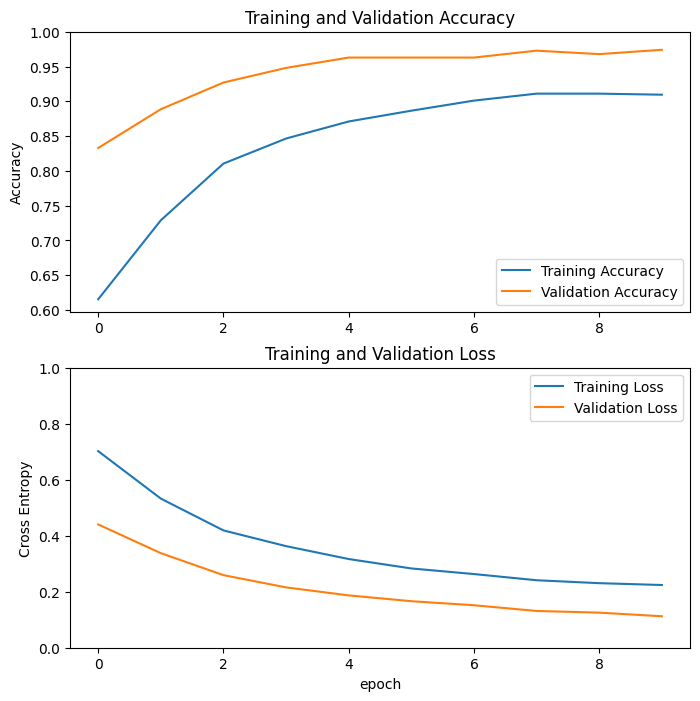

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [35]:
len(model.trainable_variables)

56

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 [==============================] - 25s 224ms/step - loss: 0.1517 - accuracy: 0.9430 - val_loss: 0.0513 - val_accuracy: 0.9876
Epoch 12/20
63/63 [==============================] - 13s 197ms/step - loss: 0.1210 - accuracy: 0.9460 - val_loss: 0.0443 - val_accuracy: 0.9864
Epoch 13/20
63/63 [==============================] - 13s 198ms/step - loss: 0.1098 - accuracy: 0.9575 - val_loss: 0.0505 - val_accuracy: 0.9802
Epoch 14/20
63/63 [==============================] - 12s 185ms/step - loss: 0.0936 - accuracy: 0.9665 - val_loss: 0.0438 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 11s 167ms/step - loss: 0.0844 - accuracy: 0.9635 - val_loss: 0.0403 - val_accuracy: 0.9876
Epoch 16/20
63/63 [==============================] - 9s 149ms/step - loss: 0.0844 - accuracy: 0.9675 - val_loss: 0.0390 - val_accuracy: 0.9876
Epoch 17/20
63/63 [==============================] - 12s 188ms/step - loss: 0.0753 - accuracy: 0.9695 - val_loss: 0.0322 - val_accuracy: 

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7809 - loss: 0.4527

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7778 - loss: 0.4580

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7762 - loss: 0.4601

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7751 - loss: 0.4609

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7743 - loss: 0.4610

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7743 - loss: 0.4600

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7746 - loss: 0.4589

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7748 - loss: 0.4575

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7750 - loss: 0.4563

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7750 - loss: 0.4558

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7753 - loss: 0.4547

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7755 - loss: 0.4538

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7757 - loss: 0.4529

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7761 - loss: 0.4518

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7766 - loss: 0.4507

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7770 - loss: 0.4497

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7775 - loss: 0.4486

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7780 - loss: 0.4475

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7786 - loss: 0.4464

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7789 - loss: 0.4459

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7795 - loss: 0.4448

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7801 - loss: 0.4436

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7804 - loss: 0.4431

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7810 - loss: 0.4420

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7818 - loss: 0.4408

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7825 - loss: 0.4395

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7829 - loss: 0.4388

W0000 00:00:1723777740.759928  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.761018  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.762009  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.763008  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.763868  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.764730  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.765679  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.766639  124620 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723777740.767538  124620 gp

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.7833 - loss: 0.4382 - val_accuracy: 0.9740 - val_loss: 0.0901


Epoch 12/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8750 - loss: 0.2900

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8819 - loss: 0.2776

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8860 - loss: 0.2764

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8862 - loss: 0.2743

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8872 - loss: 0.2727

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8858 - loss: 0.2743

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8847 - loss: 0.2745

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8845 - loss: 0.2745

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8838 - loss: 0.2754

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8832 - loss: 0.2763

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8831 - loss: 0.2766

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8832 - loss: 0.2765

22/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8836 - loss: 0.2763

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8838 - loss: 0.2762

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8840 - loss: 0.2762

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8841 - loss: 0.2763

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8842 - loss: 0.2762

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8845 - loss: 0.2759

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8846 - loss: 0.2759

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8843 - loss: 0.2764

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8842 - loss: 0.2765

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8840 - loss: 0.2767

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8839 - loss: 0.2767

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8839 - loss: 0.2765

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8840 - loss: 0.2763

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8841 - loss: 0.2761

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8842 - loss: 0.2757

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8844 - loss: 0.2754

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8845 - loss: 0.2753

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8847 - loss: 0.2749

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8849 - loss: 0.2747

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8850 - loss: 0.2743

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8851 - loss: 0.2740

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8852 - loss: 0.2737

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8853 - loss: 0.2735

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8853 - loss: 0.2733 - val_accuracy: 0.9715 - val_loss: 0.0812


Epoch 13/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9062 - loss: 0.2526

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9427 - loss: 0.2120

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9519 - loss: 0.1942

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9485 - loss: 0.1909

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9445 - loss: 0.1894

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9387 - loss: 0.1916

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9344 - loss: 0.1945

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9327 - loss: 0.1958

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9308 - loss: 0.1974

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9289 - loss: 0.1994

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9280 - loss: 0.2005

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9265 - loss: 0.2023

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9253 - loss: 0.2038

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9248 - loss: 0.2044

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9238 - loss: 0.2055

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9229 - loss: 0.2065

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9221 - loss: 0.2073

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9218 - loss: 0.2076

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9213 - loss: 0.2081

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9207 - loss: 0.2089

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9203 - loss: 0.2093

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9198 - loss: 0.2102

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9192 - loss: 0.2110

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9188 - loss: 0.2114

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9183 - loss: 0.2121

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9178 - loss: 0.2127

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9175 - loss: 0.2133

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9172 - loss: 0.2136

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9169 - loss: 0.2141

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9166 - loss: 0.2146

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9165 - loss: 0.2149

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9162 - loss: 0.2154

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9160 - loss: 0.2158

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9158 - loss: 0.2161

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9158 - loss: 0.2163

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9156 - loss: 0.2165

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9156 - loss: 0.2167 - val_accuracy: 0.9777 - val_loss: 0.0656


Epoch 14/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 1.0000 - loss: 0.0997

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9766 - loss: 0.1141

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9681 - loss: 0.1321

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9657 - loss: 0.1380

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9584 - loss: 0.1468

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9510 - loss: 0.1533

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9463 - loss: 0.1575

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9450 - loss: 0.1587

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9434 - loss: 0.1597

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9427 - loss: 0.1605

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9419 - loss: 0.1613

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9412 - loss: 0.1623

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9408 - loss: 0.1632

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9403 - loss: 0.1641

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9397 - loss: 0.1650

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9394 - loss: 0.1654

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9390 - loss: 0.1662

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9388 - loss: 0.1667

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9387 - loss: 0.1669

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9384 - loss: 0.1676

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9382 - loss: 0.1679

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9379 - loss: 0.1687

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9376 - loss: 0.1694

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9374 - loss: 0.1702

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9371 - loss: 0.1709

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9370 - loss: 0.1713

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9368 - loss: 0.1720

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9366 - loss: 0.1725

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9365 - loss: 0.1728

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9364 - loss: 0.1730

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1733

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1735

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9362 - loss: 0.1738

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9361 - loss: 0.1741

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9360 - loss: 0.1742

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9359 - loss: 0.1746

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9357 - loss: 0.1749

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9356 - loss: 0.1752

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9355 - loss: 0.1753 - val_accuracy: 0.9790 - val_loss: 0.0592


Epoch 15/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9688 - loss: 0.1888

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9514 - loss: 0.1675

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9483 - loss: 0.1590

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9491 - loss: 0.1550

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9507 - loss: 0.1513

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9514 - loss: 0.1477

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9513 - loss: 0.1464

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9513 - loss: 0.1447

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9493 - loss: 0.1469

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9483 - loss: 0.1485

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9459 - loss: 0.1516

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9439 - loss: 0.1537

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9426 - loss: 0.1551

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9422 - loss: 0.1554

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9417 - loss: 0.1559

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9409 - loss: 0.1567

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9407 - loss: 0.1570

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9404 - loss: 0.1575

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9400 - loss: 0.1583

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9398 - loss: 0.1586

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9394 - loss: 0.1591

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1593

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1596

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1603

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9386 - loss: 0.1606

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1610

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9382 - loss: 0.1617

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9381 - loss: 0.1620

43/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9380 - loss: 0.1625

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9379 - loss: 0.1628

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9377 - loss: 0.1632

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9377 - loss: 0.1634

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9376 - loss: 0.1637

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9374 - loss: 0.1640

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9372 - loss: 0.1644

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9371 - loss: 0.1646

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9370 - loss: 0.1648

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9368 - loss: 0.1651

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9366 - loss: 0.1652

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9364 - loss: 0.1655

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9363 - loss: 0.1657

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9362 - loss: 0.1658 - val_accuracy: 0.9802 - val_loss: 0.0545


Epoch 16/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9688 - loss: 0.1078

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9609 - loss: 0.1243

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9434 - loss: 0.1378

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9384 - loss: 0.1418

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9374 - loss: 0.1417

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9364 - loss: 0.1415

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9357 - loss: 0.1426

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9350 - loss: 0.1451

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9350 - loss: 0.1461

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9354 - loss: 0.1464

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9359 - loss: 0.1468

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9364 - loss: 0.1466

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9369 - loss: 0.1462

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9379 - loss: 0.1454

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9381 - loss: 0.1454

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9381 - loss: 0.1455

23/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1453

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1454

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9387 - loss: 0.1455

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1454

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9388 - loss: 0.1455

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9390 - loss: 0.1454

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1454

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1454

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1454

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9392 - loss: 0.1454

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1455

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1456

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1456

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1457

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9391 - loss: 0.1458

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9392 - loss: 0.1458

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1457

59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1458

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1458

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9393 - loss: 0.1459

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9393 - loss: 0.1459 - val_accuracy: 0.9851 - val_loss: 0.0497


Epoch 17/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8750 - loss: 0.1786

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8906 - loss: 0.1586

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9028 - loss: 0.1517

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9095 - loss: 0.1488

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9159 - loss: 0.1470

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9202 - loss: 0.1443

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9222 - loss: 0.1436

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9234 - loss: 0.1432

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9247 - loss: 0.1426

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9257 - loss: 0.1418

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9276 - loss: 0.1412

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9296 - loss: 0.1404

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9307 - loss: 0.1397

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9318 - loss: 0.1391

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9330 - loss: 0.1384

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9341 - loss: 0.1377

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9359 - loss: 0.1364

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9366 - loss: 0.1360

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9373 - loss: 0.1357

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9379 - loss: 0.1353

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9385 - loss: 0.1350

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9391 - loss: 0.1346

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9396 - loss: 0.1342

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9406 - loss: 0.1337

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9410 - loss: 0.1336

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9413 - loss: 0.1335

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9420 - loss: 0.1333

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9423 - loss: 0.1332

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9426 - loss: 0.1330

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9429 - loss: 0.1329

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9431 - loss: 0.1327

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9434 - loss: 0.1325

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9436 - loss: 0.1324

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9440 - loss: 0.1323

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9442 - loss: 0.1322

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9444 - loss: 0.1322

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9446 - loss: 0.1321

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9448 - loss: 0.1321

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9449 - loss: 0.1321

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9451 - loss: 0.1321

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9452 - loss: 0.1322

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9454 - loss: 0.1322

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9455 - loss: 0.1322

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9456 - loss: 0.1323

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9459 - loss: 0.1323

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9460 - loss: 0.1324

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9461 - loss: 0.1324

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9463 - loss: 0.1324

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9465 - loss: 0.1324

61/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9465 - loss: 0.1324

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9467 - loss: 0.1325

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9468 - loss: 0.1325 - val_accuracy: 0.9814 - val_loss: 0.0517


Epoch 18/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9688 - loss: 0.1182

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9609 - loss: 0.1178

 4/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1092

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9563 - loss: 0.1049

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9555 - loss: 0.1054

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1049

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9552 - loss: 0.1050

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9553 - loss: 0.1050

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9555 - loss: 0.1047

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9557 - loss: 0.1043

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9558 - loss: 0.1044

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9559 - loss: 0.1047

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9561 - loss: 0.1048

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9563 - loss: 0.1048

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9564 - loss: 0.1049

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9563 - loss: 0.1056

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1066

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1073

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1078

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1084

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9561 - loss: 0.1090

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9561 - loss: 0.1095

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9561 - loss: 0.1099

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9560 - loss: 0.1105

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9558 - loss: 0.1110

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9557 - loss: 0.1114

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9556 - loss: 0.1119

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9555 - loss: 0.1122

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9554 - loss: 0.1124

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9554 - loss: 0.1126

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1127

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1129

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9553 - loss: 0.1131

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9552 - loss: 0.1133

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9552 - loss: 0.1133

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9551 - loss: 0.1135

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9551 - loss: 0.1136

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9550 - loss: 0.1137

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1138

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1140

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1141

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1142

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1143

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1145

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9547 - loss: 0.1146

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1147

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9548 - loss: 0.1147

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1148

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1149

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1150

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9549 - loss: 0.1151

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9549 - loss: 0.1152

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9549 - loss: 0.1154 - val_accuracy: 0.9889 - val_loss: 0.0417


Epoch 19/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9062 - loss: 0.1450

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9219 - loss: 0.1286

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9340 - loss: 0.1224

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9368 - loss: 0.1214

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9407 - loss: 0.1175

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9437 - loss: 0.1139

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9460 - loss: 0.1114

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9502 - loss: 0.1066

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9521 - loss: 0.1043

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9533 - loss: 0.1032

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9540 - loss: 0.1027

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9545 - loss: 0.1025

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9551 - loss: 0.1026

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9556 - loss: 0.1027

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9562 - loss: 0.1027

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9564 - loss: 0.1031

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9567 - loss: 0.1033

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9569 - loss: 0.1035

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1037

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1043

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1048

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9571 - loss: 0.1053

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9572 - loss: 0.1056

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9573 - loss: 0.1058

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9573 - loss: 0.1059

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9575 - loss: 0.1060

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9576 - loss: 0.1060

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9577 - loss: 0.1060

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9578 - loss: 0.1061

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1061

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9580 - loss: 0.1061

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1061

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1062

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1063

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1065

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9581 - loss: 0.1067

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9580 - loss: 0.1068

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1070

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9579 - loss: 0.1072

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9578 - loss: 0.1075

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9576 - loss: 0.1078

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9575 - loss: 0.1081

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9575 - loss: 0.1084

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1086

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1087

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1089

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9574 - loss: 0.1090

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1091

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1092

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1093

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1094

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9573 - loss: 0.1095

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1096

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1097

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1098

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9572 - loss: 0.1098

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9571 - loss: 0.1099

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9571 - loss: 0.1101

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9570 - loss: 0.1103

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9569 - loss: 0.1105 - val_accuracy: 0.9851 - val_loss: 0.0428


Epoch 20/20


 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9375 - loss: 0.1219

 2/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9297 - loss: 0.1449

 3/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9323 - loss: 0.1463

 4/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9355 - loss: 0.1420

 5/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9384 - loss: 0.1372

 6/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9400 - loss: 0.1340

 7/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9409 - loss: 0.1320

 8/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9410 - loss: 0.1324

 9/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9418 - loss: 0.1318

10/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9429 - loss: 0.1307

11/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9440 - loss: 0.1299

12/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9443 - loss: 0.1298

13/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9447 - loss: 0.1295

14/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9453 - loss: 0.1289

15/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9456 - loss: 0.1286

16/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9461 - loss: 0.1279

17/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9463 - loss: 0.1274

18/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9467 - loss: 0.1268

19/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9471 - loss: 0.1263

20/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9474 - loss: 0.1259

21/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9477 - loss: 0.1254

22/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9480 - loss: 0.1251

23/63 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9483 - loss: 0.1249

24/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9485 - loss: 0.1247

25/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9487 - loss: 0.1244

26/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9489 - loss: 0.1242

27/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9491 - loss: 0.1241

28/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9492 - loss: 0.1239

29/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9494 - loss: 0.1237

30/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9495 - loss: 0.1235

31/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9497 - loss: 0.1233

32/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9499 - loss: 0.1231

33/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9501 - loss: 0.1229

34/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9502 - loss: 0.1226

35/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9504 - loss: 0.1224

36/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9506 - loss: 0.1222

37/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9507 - loss: 0.1220

38/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9508 - loss: 0.1219

39/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1218

40/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1218

41/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1219

42/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9509 - loss: 0.1220

43/63 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9508 - loss: 0.1221

44/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1221

45/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1222

46/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

47/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

48/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1221

49/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9509 - loss: 0.1222

50/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1224

51/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9508 - loss: 0.1226

52/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9507 - loss: 0.1227

53/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1229

54/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9506 - loss: 0.1230

55/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9505 - loss: 0.1232

56/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9504 - loss: 0.1233

57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9503 - loss: 0.1235

58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9503 - loss: 0.1236

60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9501 - loss: 0.1239

62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9500 - loss: 0.1241

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9499 - loss: 0.1243 - val_accuracy: 0.9876 - val_loss: 0.0355


In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

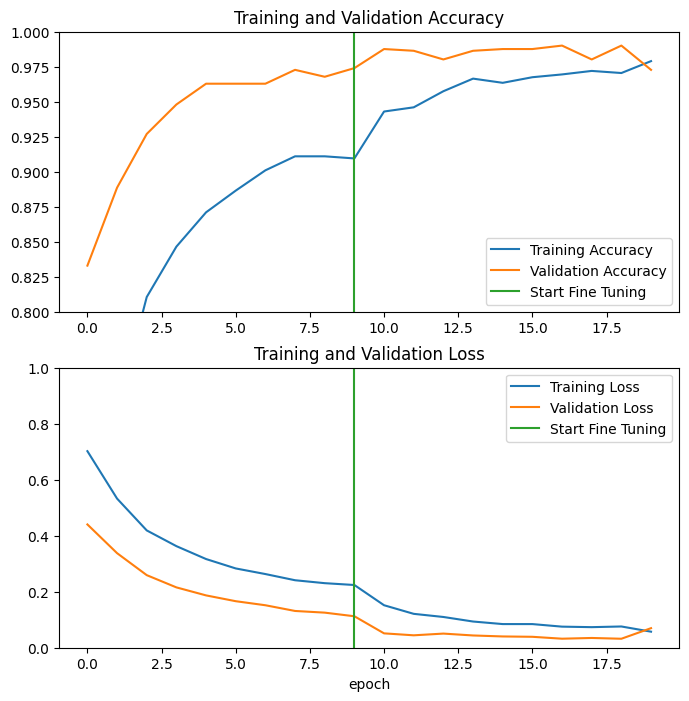

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 37ms/step - loss: 0.0726 - accuracy: 0.9688
Test accuracy : 0.96875


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9566 - loss: 0.0934

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9600 - loss: 0.0837


Test accuracy : 0.96875


Predictions:
 [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
Labels:
 [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0]


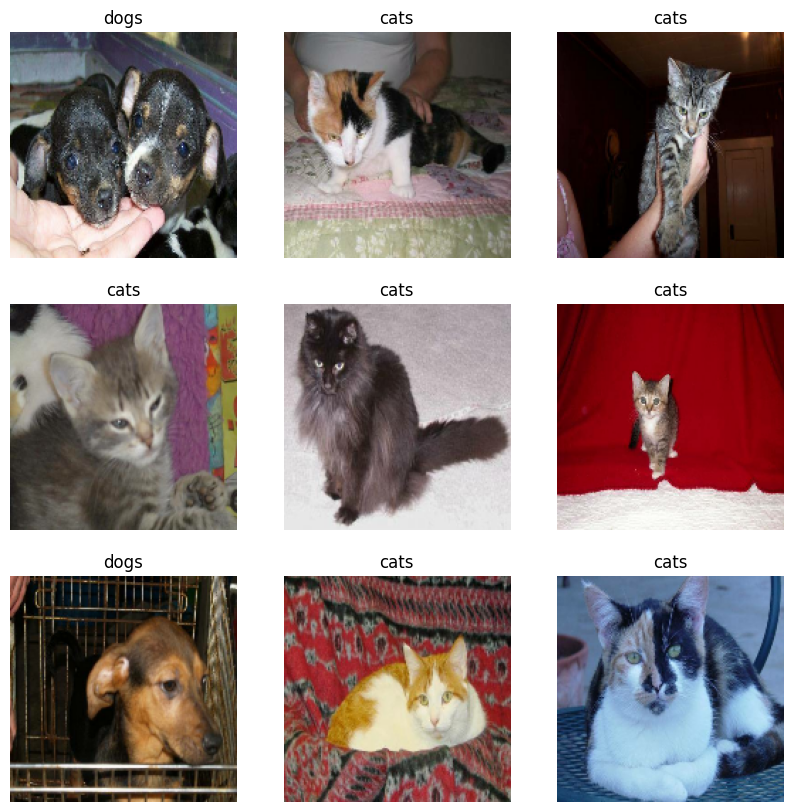

In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")